In [1]:
import pandas as pd
from functools import partial
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
import torch

from scripts.dataset import MultimodalDataset, collate_fn, draw_item, get_data, train_transforms, val_transforms

d:\final\calories\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\final\calories\.venv\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


# Подготовка и анализ данных

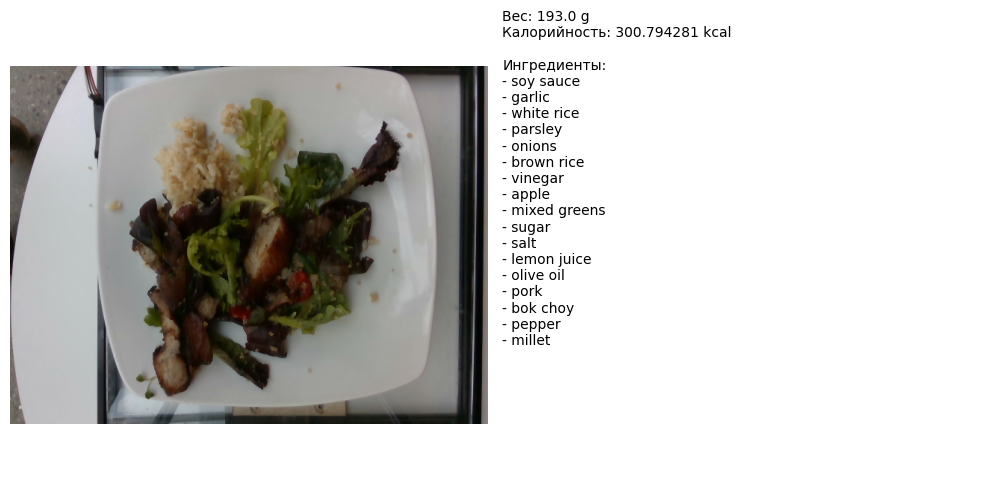

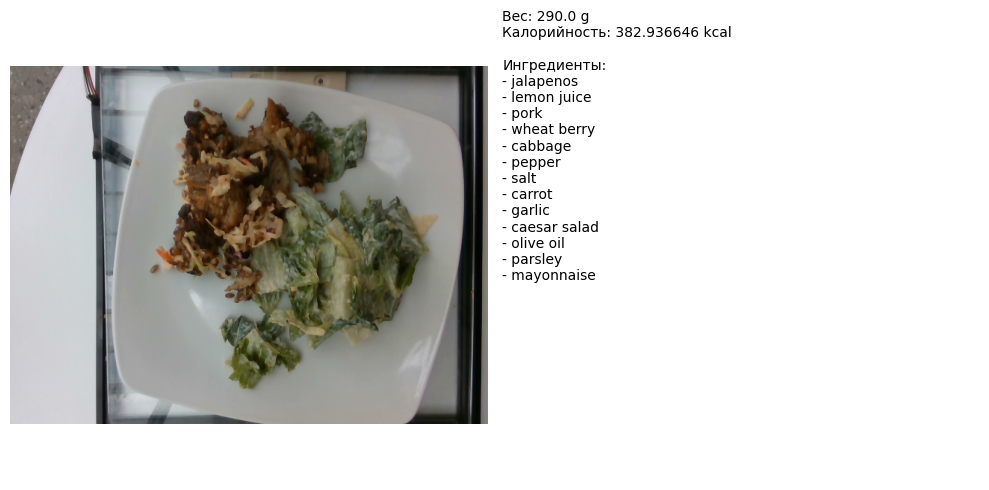

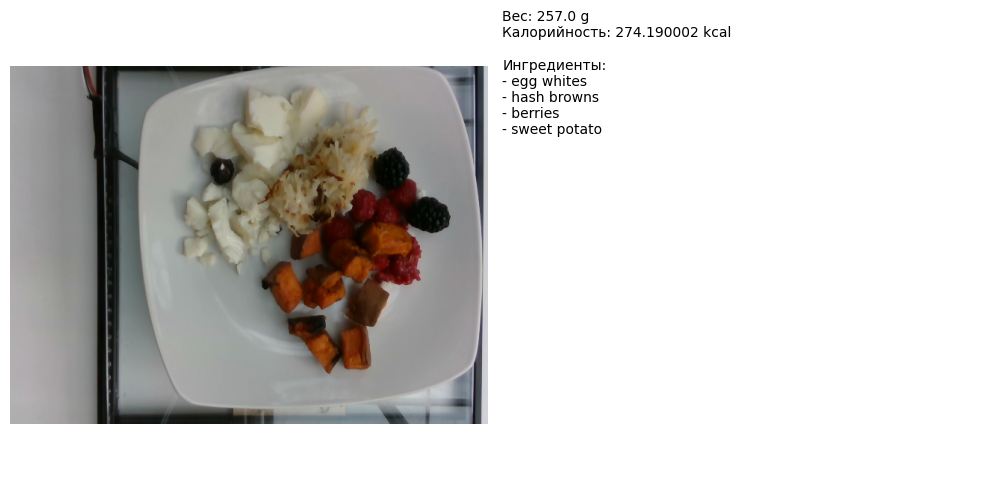

In [2]:
train_data, test_data = get_data("data/dish.csv")

ingredients = pd.read_csv("data/ingredients.csv")

data_example = MultimodalDataset(test_data, ingredients, transforms=None)

for i in range(3):
    draw_item(data_example[i])


Выводы по имеюшимся данным

# Объявление и обучение модели

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text_model = "bert-base-uncased"
image_model = 'tf_efficientnet_b0'

train_df, val_df = train_test_split(
    train_data,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

train_dataset = MultimodalDataset(train_df, ingredients, text_model=text_model, image_model=image_model, transforms=train_transforms)
val_dataset = MultimodalDataset(val_df, ingredients, text_model=text_model, image_model=image_model, transforms=val_transforms)
test_dataset = MultimodalDataset(test_data, ingredients, text_model=text_model, image_model=image_model, transforms=val_transforms)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
)

print(train_dataset[0])


{'total_mass': np.float64(292.0), 'total_calories': np.float64(419.438782), 'ingredients': ['pepper', 'white rice', 'mixed greens', 'garlic', 'soy sauce', 'millet', 'lemon juice', 'bok choy', 'olive oil', 'onions', 'vinegar', 'green beans', 'pork', 'apple', 'sugar', 'salt', 'parsley'], 'image': tensor([[[-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
         [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
         [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
         ...,
         [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
         [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
         [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008]],

        [[-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
         [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
         [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
         ...,
         [-2.0182, -2.0182, -2.0182